In [1]:
from functools import partial
import os, sys
import numpy as np
from numpy import log, exp, sqrt
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import *
from src.train import *
from src.model import Environment, Agent, ReplayBuffer

In [2]:
def estimate_option_price(agent, env, n_paths=10000):
    """
    Estimate the option price using the trained agent.
    """
    total_rewards = []

    for _ in range(n_paths):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    # Return the average reward as the estimated price
    return np.mean(total_rewards)

running S_0 = 120, T = 1, sig = 0.2


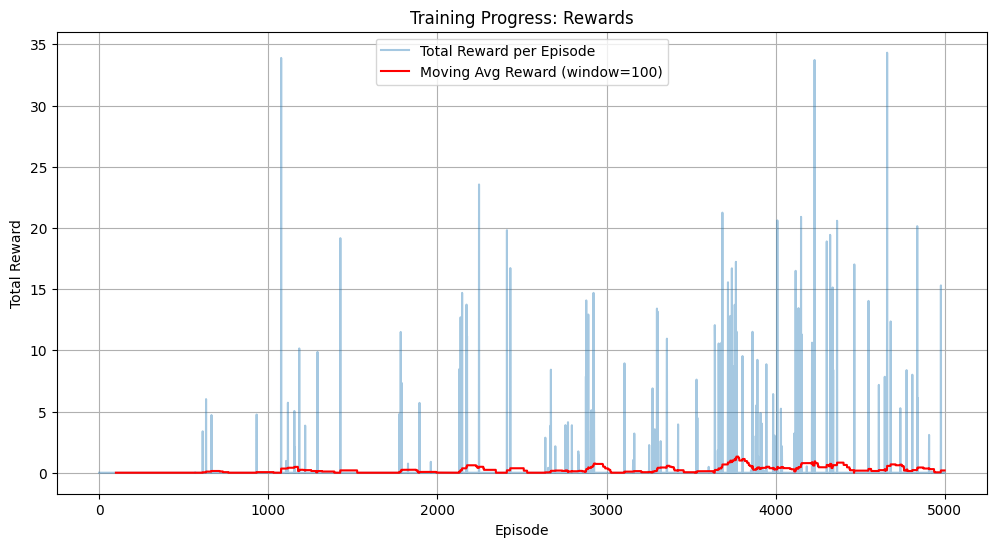

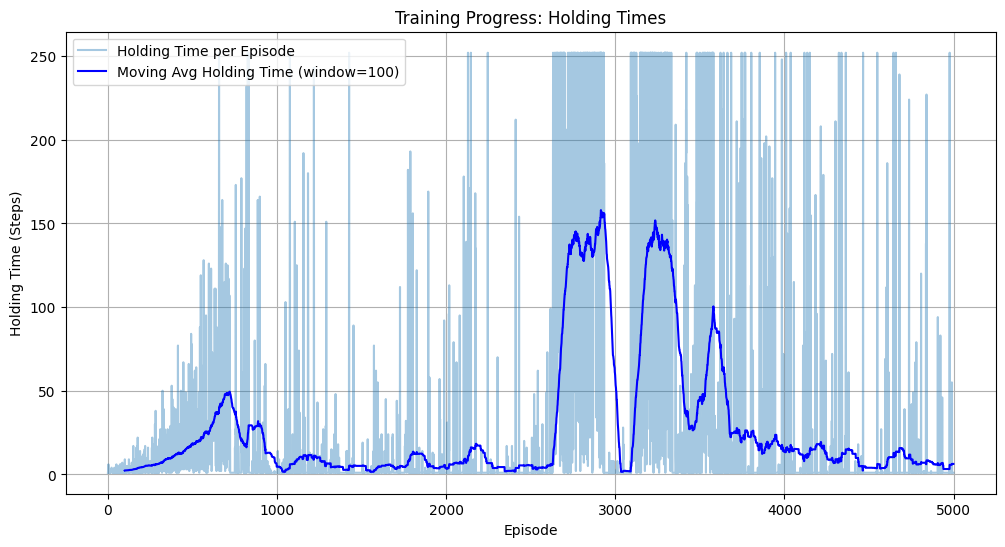

priced: 0.6061470765144507
running S_0 = 120, T = 2, sig = 0.2


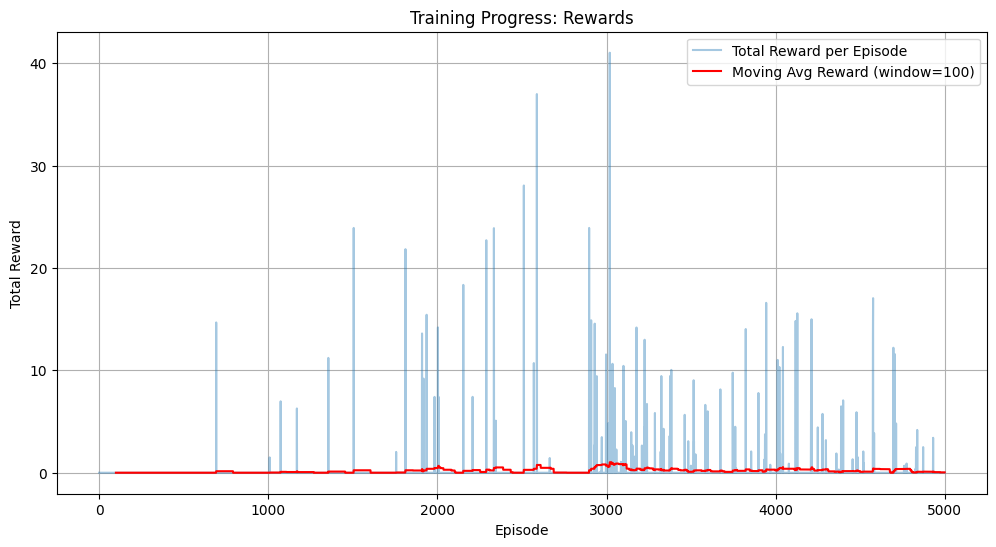

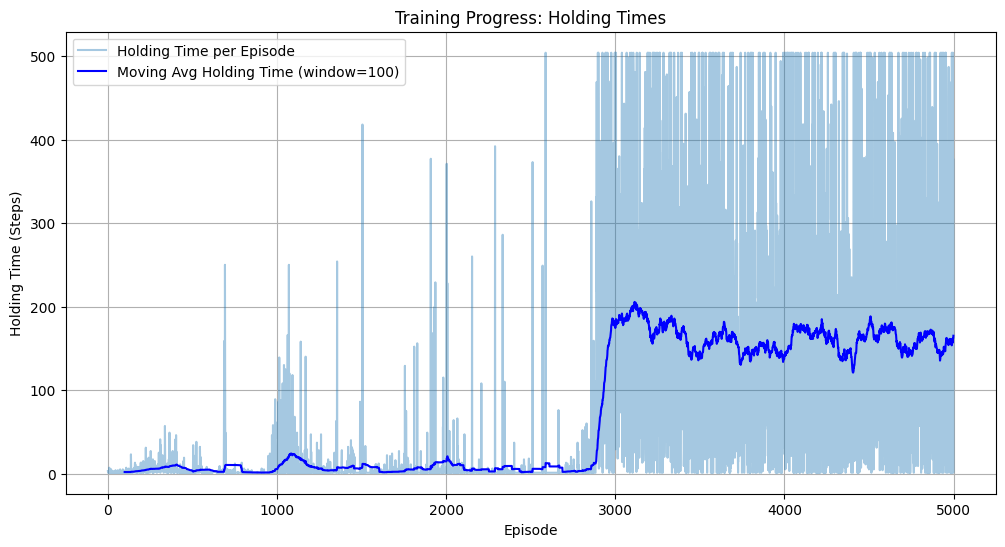

priced: 0.11710367975199387
running S_0 = 120, T = 1, sig = 0.4


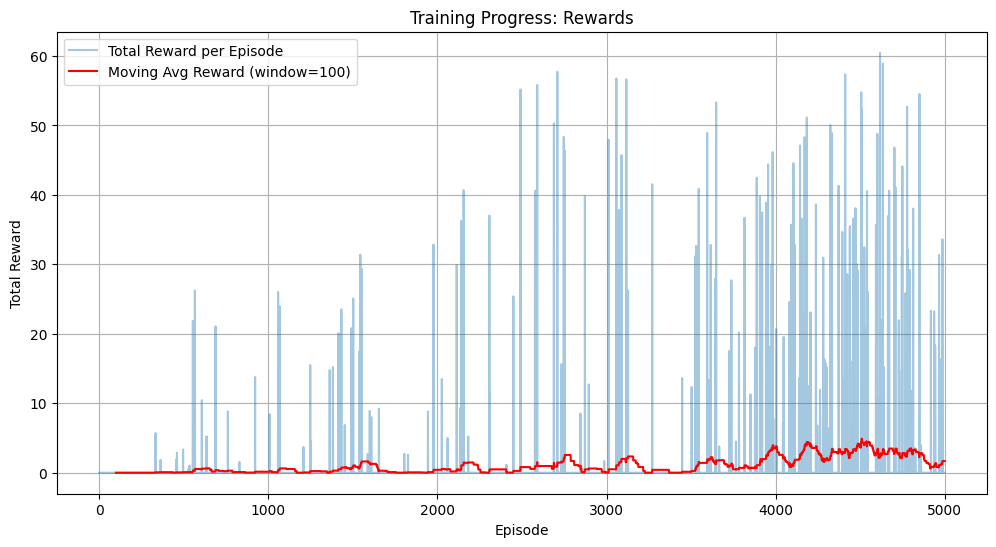

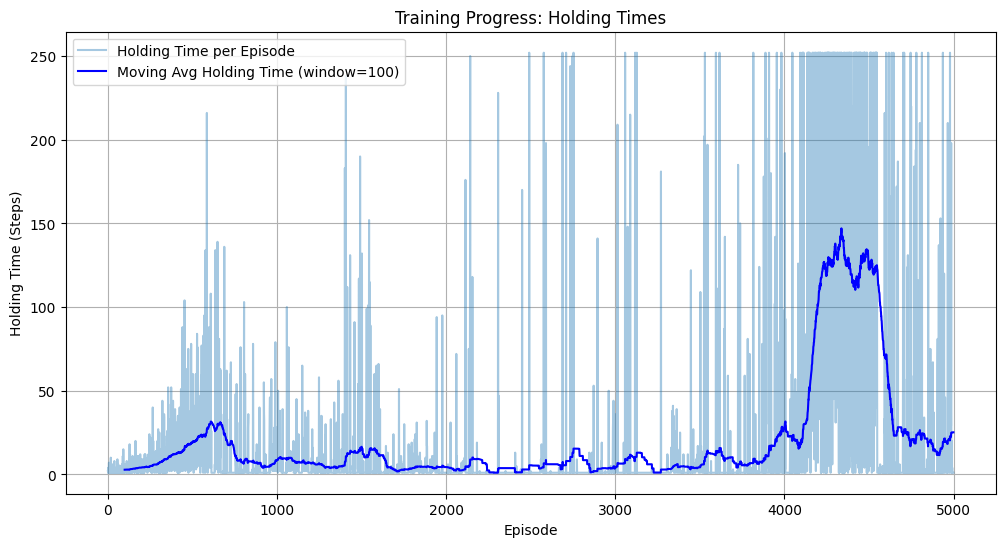

priced: 1.9352488444627949
running S_0 = 120, T = 2, sig = 0.4


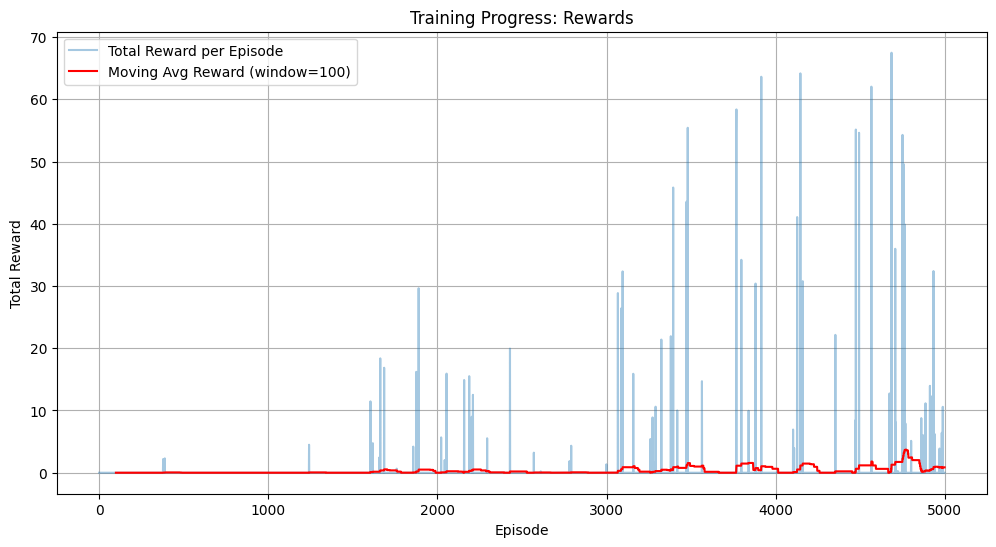

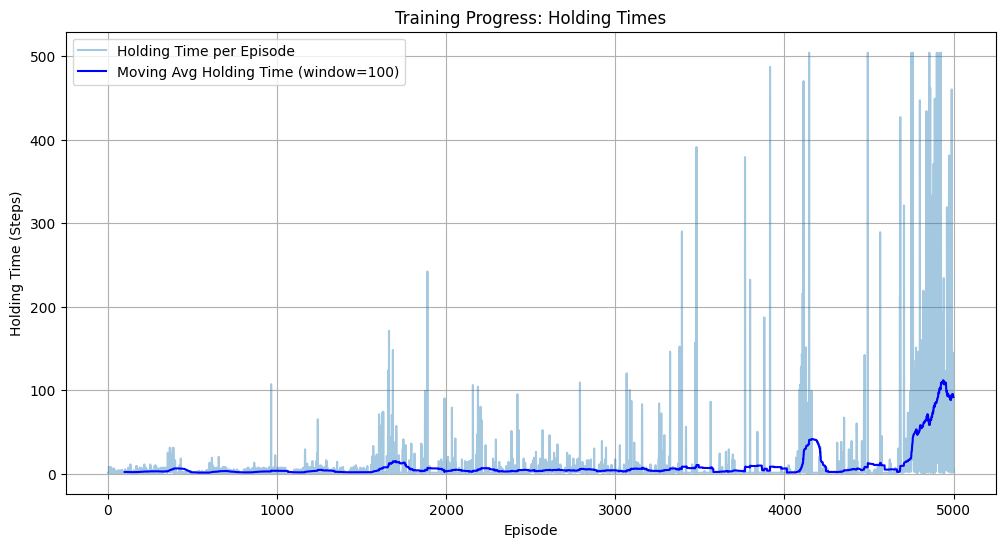

priced: 0.48417426979876516
running S_0 = 110, T = 1, sig = 0.2


KeyboardInterrupt: 

In [3]:
# Use agent to estimate American option prices
def agent_pricing(S, K, T, r, sigma, steps, episodes, update_target_every ):
    agent = Agent(
        obssize=6,  
        actsize=2,
        hidden_dim=128,
        depth=2,
        lr=1e-3,
        buffer_size=10000,
        batch_size=128,
        gamma=0.999,
        eps_start=1.0,
        eps_min=0.01,
        eps_decay=0.995)

    price_paths = generate_gbm_paths(10000, steps*T, 0, T, S, r, 0, sigma)
    env = Environment(price_paths=price_paths, K=K, t1=0, t2=T, r=r, option_type="put")
    agent.initialize_buffer(env, steps=100000)  
    rewards = train(agent, env, episodes, update_target_every, verbose = False)
    return estimate_option_price(agent, env, n_paths=1000)

# Parameters
K = 100
r = 0.04
steps = 252
episodes = 5000
update_target_every = 50

# S0, sigma, and T combinations
#S0_values = [80, 85, 90, 95, 100, 105, 110, 115, 120]
S0_values = [80, 95, 100, 110, 120]
sigma_values = [0.20, 0.40]
T_values = [1, 2]

# DataFrame to store results
results = []

for S in S0_values[::-1]:
    for sigma in sigma_values:
        for T in T_values:
            print(f"running S_0 = {S}, T = {T}, sig = {sigma}")

            american_price_agent = agent_pricing(S = S, K = K, T = T, r = r, sigma = sigma, steps = steps, episodes=episodes, update_target_every=update_target_every)

            print(f"priced: {american_price_agent}")

            results.append({
                "S (0)": S,
                "σ": sigma,
                "T": T,
                "Agent Estimated American": american_price_agent,
            })

# Create DataFrame
df = pd.DataFrame(results)
